In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tfrecorder import TFrecorder
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%pylab inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


# input_fn's

In [2]:
tfr = TFrecorder()
def input_fn_maker(path, data_info_path, shuffle=False, batch_size = 1, epoch = 1, padding = None):
    def input_fn():
        filenames = tfr.get_filenames(path=path, shuffle=shuffle)
        dataset=tfr.get_dataset(paths=filenames, data_info=data_info_path, shuffle = shuffle, 
                            batch_size = batch_size, epoch = epoch, padding =padding)
        iterator = dataset.make_one_shot_iterator()
        return iterator.get_next()
    return input_fn

padding_info = ({'image':[784,],'label':[]})
test_input_fn = input_fn_maker('mnist_tfrecord/test/',  'mnist_tfrecord/data_info.csv',batch_size = 512,
                               padding = padding_info)
train_input_fn = input_fn_maker('mnist_tfrecord/train/',  'mnist_tfrecord/data_info.csv', shuffle=True, batch_size = 128,
                               padding = padding_info)
train_eval_fn = input_fn_maker('mnist_tfrecord/train/',  'mnist_tfrecord/data_info.csv', batch_size = 512,
                               padding = padding_info)

# model

In [3]:
def model_fn(features, mode):
    # reshape 784维的图片到28x28的平面表达，1为channel数
    features['image'] = tf.reshape(features['image'],[-1,28,28,1])
    # shape: [None,28,28,1]
    conv1 = tf.layers.conv2d(
        inputs=features['image'],
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu,
        name = 'conv1')
    # shape: [None,28,28,32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2, name= 'pool1')
    # shape: [None,14,14,32]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu,
        name = 'conv2')
    # shape: [None,14,14,64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2, name= 'pool2')
    # shape: [None,7,7,64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64], name= 'pool2_flat')
    # shape: [None,3136]
    dense1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name= 'dense1')
    # shape: [None,1024]
    dropout = tf.layers.dropout(inputs=dense1, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    # shape: [None,1024]
    logits = tf.layers.dense(inputs=dropout, units=10, name= 'output')
    # shape: [None,10]
    predictions = {
        "image":features['image'],
        "conv1_out":conv1,
        "pool1_out":pool1,
        "conv2_out":conv2,
        "pool2_out":pool2,
        "pool2_flat_out":pool2_flat,
        "dense1_out":dense1,
        "logits":logits,
        "classes": tf.argmax(input=logits, axis=1),
        "labels": features['label'],
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
        }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=features['label'], logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
        train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=features['label'], predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

# logging

In [4]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor",
                 "probabilities": "softmax_tensor",}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

# create estimator

In [5]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=model_fn, model_dir="mnist_model_cnn")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'mnist_model_cnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0c2f80def0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# train

In [6]:
mnist_classifier.train(
    input_fn=train_input_fn)

read dataframe from mnist_tfrecord/train/train23000_24000.tfrecord x 55
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from mnist_model_cnn/model.ckpt-860
INFO:tensorflow:Saving checkpoints for 861 into mnist_model_cnn/model.ckpt.
INFO:tensorflow:loss = 0.0625041, step = 861
INFO:tensorflow:global_step/sec: 7.44642
INFO:tensorflow:loss = 0.0420813, step = 961 (13.433 sec)
INFO:tensorflow:global_step/sec: 7.51289
INFO:tensorflow:loss = 0.0091515, step = 1061 (13.309 sec)
INFO:tensorflow:global_step/sec: 7.47076
INFO:tensorflow:loss = 0.00884305, step = 1161 (13.385 sec)
INFO:tensorflow:global_step/sec: 7.55675
INFO:tensorflow:loss = 0.0223666, step = 1261 (13.233 sec)
INFO:tensorflow:Saving checkpoints for 1290 into mnist_model_cnn/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00996943.


# evaluate train set 

In [7]:
eval_results = mnist_classifier.evaluate(input_fn=train_eval_fn)
print('train set')
print(eval_results)

read dataframe from mnist_tfrecord/train/train19000_20000.tfrecord x 55
INFO:tensorflow:Starting evaluation at 2018-04-07-13:39:30
INFO:tensorflow:Restoring parameters from mnist_model_cnn/model.ckpt-1290
INFO:tensorflow:Finished evaluation at 2018-04-07-13:39:43
INFO:tensorflow:Saving dict for global step 1290: accuracy = 0.993036, global_step = 1290, loss = 0.0218582
train set
{'accuracy': 0.99303639, 'loss': 0.021858249, 'global_step': 1290}


# evaluate test set 

In [8]:
eval_results = mnist_classifier.evaluate(input_fn=test_input_fn)
print('test set')
print(eval_results)

read dataframe from mnist_tfrecord/test/test1000_2000.tfrecord x 10
INFO:tensorflow:Starting evaluation at 2018-04-07-13:40:01
INFO:tensorflow:Restoring parameters from mnist_model_cnn/model.ckpt-1290
INFO:tensorflow:Finished evaluation at 2018-04-07-13:40:04
INFO:tensorflow:Saving dict for global step 1290: accuracy = 0.989, global_step = 1290, loss = 0.0329792
test set
{'accuracy': 0.98900002, 'loss': 0.03297919, 'global_step': 1290}


# predict

In [9]:
predicts =list(mnist_classifier.predict(input_fn=test_input_fn))

read dataframe from mnist_tfrecord/test/test1000_2000.tfrecord x 10
INFO:tensorflow:Restoring parameters from mnist_model_cnn/model.ckpt-1290


# print predictions

In [10]:
predicts[0].keys()

dict_keys(['image', 'conv1_out', 'pool1_out', 'conv2_out', 'pool2_out', 'pool2_flat_out', 'dense1_out', 'logits', 'classes', 'labels', 'probabilities'])

In [11]:
predicts[0]['image'].shape

(28, 28, 1)

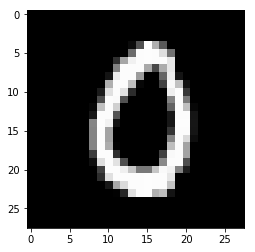

In [12]:
plt.imshow(predicts[0]['image'][:,:,0],cmap = plt.cm.gray)

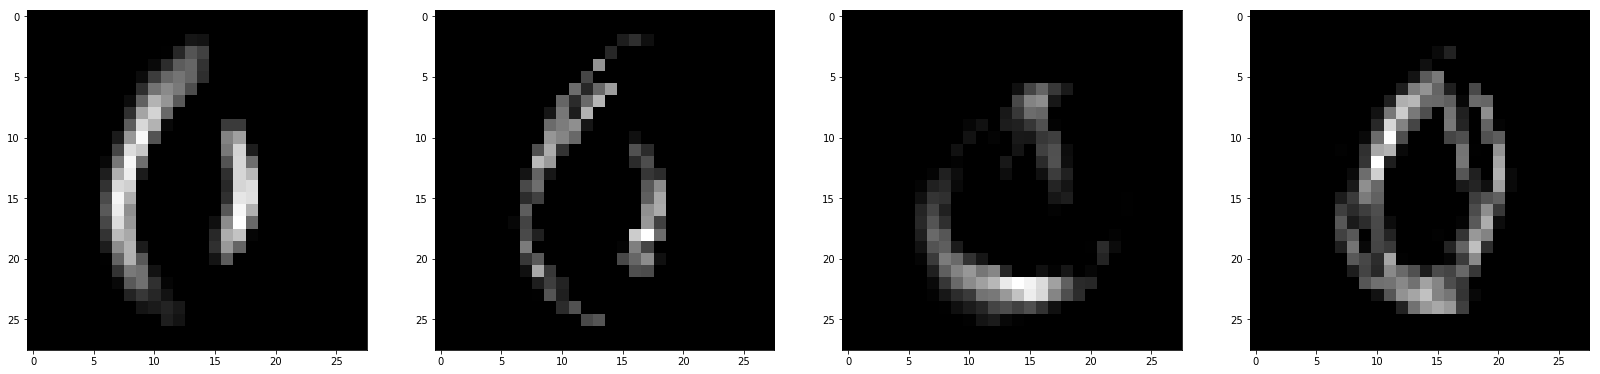

In [13]:
plt.figure(num=4,figsize=(28,28))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(predicts[0]['conv1_out'][:,:,i],cmap = plt.cm.gray)
plt.savefig('conv1_out.png')

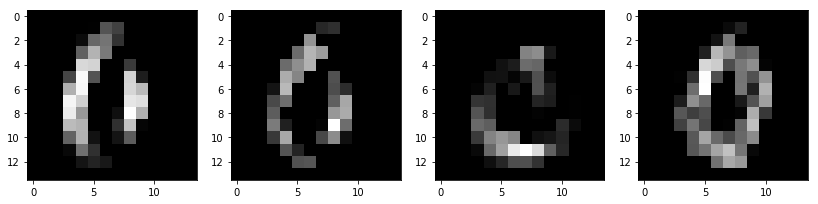

In [14]:
plt.figure(num=4,figsize=(14,14))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(predicts[0]['pool1_out'][:,:,i],cmap = plt.cm.gray)
plt.savefig('pool1_out.png')

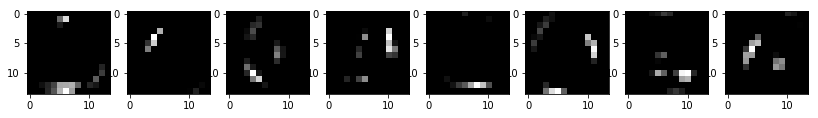

In [15]:
plt.figure(num=8,figsize=(14,14))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(predicts[0]['conv2_out'][:,:,i],cmap = plt.cm.gray)
plt.savefig('conv2_out.png')

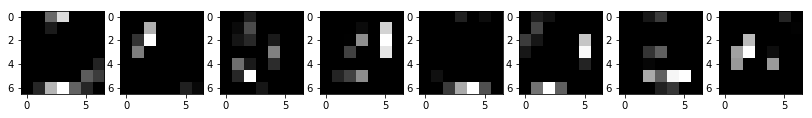

In [16]:
plt.figure(num=8,figsize=(14,14))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(predicts[0]['pool2_out'][:,:,i],cmap = plt.cm.gray)
plt.savefig('pool2_out.png')